In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
input_path = Path("../data/processed/cleaned_gravity_speed_data.csv")
df = pd.read_csv(input_path)
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded dataset with 1000 rows and 9 columns.


In [3]:
target = "time_difference_s"
features = df.drop(columns=[target]).select_dtypes(include=["float64", "int64"]).columns.tolist()
X = df[features]
y = df[target]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

In [6]:
target = "time_difference_s"
features = df.drop(columns=[target]).select_dtypes(include=["float64", "int64"]).columns.tolist()
X = df[features]
y = df[target]

data = pd.concat([X, y], axis=1)
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf_model = grid_rf.best_estimator_
rf_preds = best_rf_model.predict(X_test)

print(f"Best RF Params: {grid_rf.best_params_}")


Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [7]:
def evaluate(y_true, y_pred, model_name="Model"):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {model_name} Performance")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2:.4f}")


In [8]:
evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest (Tuned)")


📊 Linear Regression Performance
  - RMSE: 0.1217
  - MAE:  0.1040
  - R²:   -0.0029
📊 Random Forest (Tuned) Performance
  - RMSE: 0.0004
  - MAE:  0.0003
  - R²:   1.0000


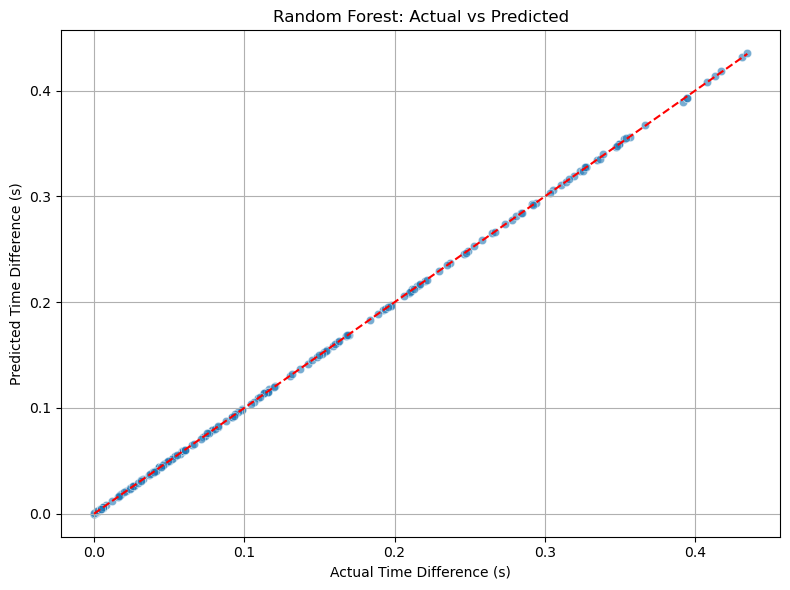

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.6, edgecolor="white")
plt.xlabel("Actual Time Difference (s)")
plt.ylabel("Predicted Time Difference (s)")
plt.title("Random Forest: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/figures/rf_actual_vs_predicted.png", dpi=300)
plt.show()


In [10]:
model_dir = Path("../models")
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(lr_model, model_dir / "linear_model.joblib")
joblib.dump(best_rf_model, model_dir / "rf_model.joblib")
print("✅ Models saved in 'models/' directory.")


✅ Models saved in 'models/' directory.
